In [1]:
import os
from pathlib import Path

DATA_DIR = r"C:\project9\data\data"
p = Path(DATA_DIR)

if not p.exists():
    raise FileNotFoundError(
        f"Папка {DATA_DIR} не найдена."
    )

file_count = sum(len(files) for _, _, files in os.walk(DATA_DIR))
print(f"папка '{DATA_DIR}' обнаружена.")
print(f"Всего файлов в: {file_count}")


папка 'C:\project9\data\data' обнаружена.
Всего файлов в: 225312


In [2]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

CHAR_SET = [")","(","+","-",",","0","1","2","3","4","5","6","7","8","9","X","h","t","*","w","y"]

def random_sequence(length):
    return ''.join(random.choice(CHAR_SET) for _ in range(length))

def pick_files_for_sequence(seq, data_root=DATA_DIR):
    files_out = []
    for ch in seq:
        folder = "times" if ch == "*" else ch
        folder_path = os.path.join(data_root, folder)

        if not os.path.isdir(folder_path):
            raise FileNotFoundError(f"Для символа '{ch}' нет папки: {folder_path}")

        all_files = [f for f in os.listdir(folder_path)
                     if os.path.isfile(os.path.join(folder_path, f))]

        chosen = random.choice(all_files)
        files_out.append(os.path.join(folder_path, chosen))
    return files_out


In [3]:
def concat_images_horiz(paths, spacing=30):
    imgs = [cv2.imread(p, cv2.IMREAD_COLOR) for p in paths]
    imgs = [cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in imgs]

    max_h = max(im.shape[0] for im in imgs)
    total_w = sum(im.shape[1] for im in imgs) + spacing * (len(imgs) - 1)

    canvas = np.ones((max_h, total_w), dtype=np.uint8) * 255

    x = 0
    for im in imgs:
        h, w = im.shape
        y = (max_h - h) // 2
        canvas[y:y+h, x:x+w] = im
        x += w + spacing

    return canvas, paths


Сгенерированная строка: 50)82*27+t
Выбранные изображения:
C:\project9\data\data\5\5_103244.jpg
C:\project9\data\data\0\exp31863.jpg
C:\project9\data\data\)\exp37416.jpg
C:\project9\data\data\8\exp59204.jpg
C:\project9\data\data\2\exp96738.jpg
C:\project9\data\data\times\times_10173.jpg
C:\project9\data\data\2\2_3441.jpg
C:\project9\data\data\7\7_84746.jpg
C:\project9\data\data\+\exp16196.jpg
C:\project9\data\data\t\exp6736.jpg


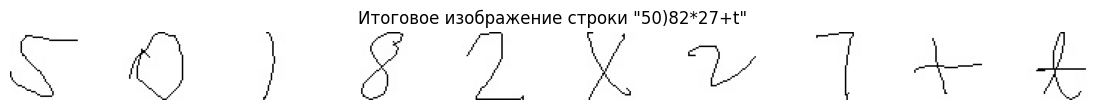

In [4]:
seq = random_sequence(10)
print("Сгенерированная строка:", seq)

paths = pick_files_for_sequence(seq)
print("Выбранные изображения:")
for p in paths:
    print(p)

canvas, _ = concat_images_horiz(paths, spacing=30)

plt.figure(figsize=(14,2))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title(f'Итоговое изображение строки "{seq}"')
plt.show()


In [5]:
def normalize_roi(roi, out_size=45):
    if roi is None or roi.size == 0:
        return np.ones((out_size, out_size), dtype=np.uint8) * 255

    h, w = roi.shape

    if h > out_size or w > out_size:
        scale = min(out_size / h, out_size / w)
        roi = cv2.resize(
            roi,
            (max(1, int(w * scale)), max(1, int(h * scale))),
            interpolation=cv2.INTER_AREA
        )
        h, w = roi.shape

    canvas = np.ones((out_size, out_size), dtype=np.uint8) * 255
    y = (out_size - h) // 2
    x = (out_size - w) // 2
    canvas[y:y+h, x:x+w] = roi

    return cv2.bitwise_not(canvas)


In [6]:
def segment_characters_from_image(img_gray, min_area=80):
    _, thr = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]

    boxes = [b for b in boxes if b[2] * b[3] >= min_area]
    boxes = sorted(boxes, key=lambda b: b[0])

    rois = []
    for (x, y, w, h) in boxes:
        roi = img_gray[y:y+h, x:x+w]
        rois.append(normalize_roi(roi, out_size=45))

    return rois, boxes


Кол-во найденных символов: 10


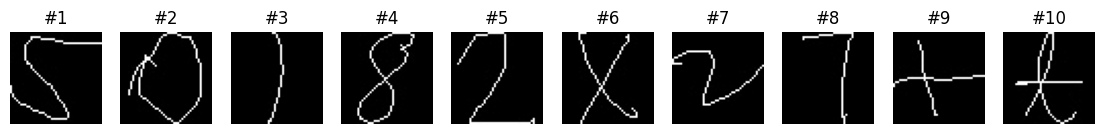

In [7]:
rois, boxes = segment_characters_from_image(canvas)
print("Кол-во найденных символов:", len(rois))

if len(rois) > 0:
    plt.figure(figsize=(14,2))
    for i, r in enumerate(rois):
        plt.subplot(1, len(rois), i+1)
        plt.imshow(r, cmap='gray')
        plt.axis('off')
        plt.title(f'#{i+1}')
    plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def build_dataset_from_folders(data_root=DATA_DIR, out_size=45, chars=CHAR_SET):
    X, y = [], []
    stats = {}

    for ch in chars:
        folder = "times" if ch == "*" else ch
        folder_path = os.path.join(data_root, folder)

        if not os.path.isdir(folder_path):
            print(f"Пропуск '{ch}' — нет папки: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path)
                 if os.path.isfile(os.path.join(folder_path, f))]

        stats[ch] = len(files)

        for fname in files:
            img = cv2.imread(os.path.join(folder_path, fname), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img_n = normalize_roi(img, out_size)
            X.append(img_n.flatten())
            y.append(ch)

    print("\nСтатистика по символам:")
    stat_line = " | ".join([f"{ch}: {count}" for ch, count in stats.items()])
    print(stat_line)

    return np.array(X), np.array(y)

In [9]:
X_all, y_all = build_dataset_from_folders(DATA_DIR, out_size=45)
print(f"\nВсего образцов: {len(X_all)}")

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.1, stratify=y_all, random_state=42
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

k_list = [1, 3, 5, 7]
models = {}
accs = {}

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    models[k] = clf
    accs[k] = acc

best_k = max(accs, key=accs.get)
best_model = models[best_k]

final_knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
final_knn.fit(X_all, y_all)

print(f"KNN обучен (k={best_k}).")


Статистика по символам:
): 14355 | (: 14294 | +: 25112 | -: 33997 | ,: 1906 | 0: 6914 | 1: 26520 | 2: 26141 | 3: 10909 | 4: 7396 | 5: 3545 | 6: 3118 | 7: 2909 | 8: 3068 | 9: 628 | X: 26594 | h: 1464 | t: 3274 | *: 3251 | w: 556 | y: 9340

Всего образцов: 225291
Train: 202761, Test: 22530
KNN обучен (k=1).


In [10]:
from sklearn.metrics import classification_report

rois, boxes = segment_characters_from_image(canvas, min_area=100)
print("ROI найдено:", len(rois))

pred = []
for r in rois:
    v = r.flatten().reshape(1, -1)
    pred.append(final_knn.predict(v)[0])

pred_str = ''.join(pred)

print("\nРЕЗУЛЬТАТ РАСПОЗНАВАНИЯ")
print("полученная строка:   ", pred_str)
print("Ожидаемая строка:    ", seq)

true_chars = list(seq)
pred_chars = list(pred)

if len(pred_chars) < len(true_chars):
    pred_chars += [""] * (len(true_chars) - len(pred_chars))
elif len(pred_chars) > len(true_chars):
    pred_chars = pred_chars[:len(true_chars)]


print("\анализ по символам:")

unique_labels = sorted(set(true_chars + pred_chars))
stats = []

for ch in unique_labels:
    tp = sum(1 for t, p in zip(true_chars, pred_chars) if t == ch and p == ch)
    fp = sum(1 for t, p in zip(true_chars, pred_chars) if t != ch and p == ch)
    fn = sum(1 for t, p in zip(true_chars, pred_chars) if t == ch and p != ch)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = (2 * precision * recall / (precision + recall)
                 if (precision + recall) > 0 else 0)

    stats.append((ch, precision, recall, f1, tp + fn))

for ch, p, r, f1, sup in stats:
    print(f" ● '{ch}': верн={p*100:.1f}%  наход={r*100:.1f}%  f1={f1*100:.1f}%  (n={sup})")


ROI найдено: 10

РЕЗУЛЬТАТ РАСПОЗНАВАНИЯ
полученная строка:    50)82*27+t
Ожидаемая строка:     50)82*27+t
\анализ по символам:
 ● ')': верн=100.0%  наход=100.0%  f1=100.0%  (n=1)
 ● '*': верн=100.0%  наход=100.0%  f1=100.0%  (n=1)
 ● '+': верн=100.0%  наход=100.0%  f1=100.0%  (n=1)
 ● '0': верн=100.0%  наход=100.0%  f1=100.0%  (n=1)
 ● '2': верн=100.0%  наход=100.0%  f1=100.0%  (n=2)
 ● '5': верн=100.0%  наход=100.0%  f1=100.0%  (n=1)
 ● '7': верн=100.0%  наход=100.0%  f1=100.0%  (n=1)
 ● '8': верн=100.0%  наход=100.0%  f1=100.0%  (n=1)
 ● 't': верн=100.0%  наход=100.0%  f1=100.0%  (n=1)


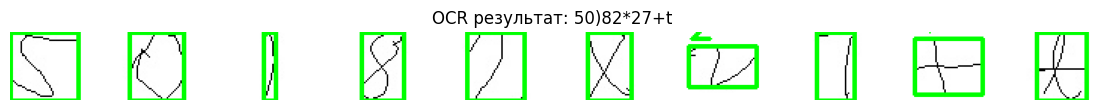

In [11]:
debug_img = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)

for (x,y,w,h), lbl in zip(boxes, pred):
    cv2.rectangle(debug_img, (x,y), (x+w,y+h), (0,255,0), 2)
    cv2.putText(debug_img, lbl, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

plt.figure(figsize=(14,2))
plt.imshow(debug_img)
plt.axis('off')
plt.title(f"OCR результат: {pred_str}")
plt.show()
